# Driver's License Extraction using Agentic IDP

This notebook demonstrates how to use the structured output functionality from `agentic_idp` directly to extract information from driver's license documents.

## Features
- Direct use of `structured_output` from agentic IDP
- Complex nested data structures (Address within License)
- Field validation using Pydantic validators
- Both image and text extraction examples
- Jupyter-compatible implementation

## 1. Setup and Imports

In [ ]:
%env AWS_PROFILE=
%env AWS_DEFAULT_REGION=
%env AWS_ACCOUNT_ID=

env: AWS_PROFILE=genaiidp-dev-Admin
env: AWS_DEFAULT_REGION=us-east-2
env: AWS_ACCOUNT_ID=195275636621


In [37]:
# Standard imports
import json
import os
import sys
from datetime import datetime
from pathlib import Path
from typing import Annotated
from deepdiff import DeepDiff
# Add parent directory to path for imports
sys.path.insert(0, str(Path().resolve().parent.parent))

# Pydantic for data models
# PIL for image handling
from PIL import Image
from pydantic import BaseModel, Field, field_validator

# IDP Common imports
from lib.idp_common_pkg.idp_common.extraction.agentic_idp import (
    structured_output,
    structured_output_async,
)

print("✅ Imports successful")

✅ Imports successful


## 2. Define Data Models

We'll define a nested structure for extracting driver's license information with validation.

In [ ]:
class Address(BaseModel):
    """Address information from the license"""
    city: str = Field(description="City name")
    state: str = Field(description="State abbreviation (e.g., CA, NY)")
    street: str = Field(description="Street address including number")
    zip_code: str = Field(description="ZIP code (5 or 9 digits)")


class License(BaseModel):
    """Complete driver's license information"""
    sex: str = Field(description="Sex/Gender marker (M/F/X)")
    license_class: str = Field(description="License class (e.g., C, CDL, etc.)")
    height: str = Field(description="Height (e.g., 5'10\")")
    weight: str = Field(description="Weight in pounds")
    address: Address = Field(description="Full address of the license holder")
    eye_color: str = Field(description="Eye color abbreviation (e.g., BRN, BLU), make it lowercase")
    last_name: str = Field(description="Last name/surname")
    middle_name: str = Field(description="Middle name")
    first_name: str = Field(description="First name")
    issue_date: Annotated[
        str,
        Field(description="The date the license was issued formatted as MM/DD/YYYY"),
    ]
    date_of_birth: Annotated[
        str, Field(description="Date of birth formatted as MM/DD/YYYY")
    ]
    expiration_date: Annotated[
        str, Field(description="License expiration date formatted as MM/DD/YYYY")
    ]
    driver_license_number: str = Field(description="Driver license number/ID")

    @field_validator("issue_date", "date_of_birth", "expiration_date")
    def validate_date_format(cls, value) -> str:
        """Validate that dates are in MM/DD/YYYY format"""
        try:
            datetime.strptime(value, "%m/%d/%Y")
        except Exception:
            raise ValueError(f"Date '{value}' should be formatted as MM/DD/YYYY")
        return value
    
    @field_validator("eye_color")
    def lowercase_eye_color(cls, value: str) -> str:
        return value.lower()

print("✅ Data models defined")
print(json.dumps(License.model_json_schema(), indent=2))

✅ Data models defined
{
  "$defs": {
    "Address": {
      "description": "Address information from the license",
      "properties": {
        "city": {
          "description": "City name",
          "title": "City",
          "type": "string"
        },
        "state": {
          "description": "State abbreviation (e.g., CA, NY)",
          "title": "State",
          "type": "string"
        },
        "street": {
          "description": "Street address including number",
          "title": "Street",
          "type": "string"
        },
        "zip_code": {
          "description": "ZIP code (5 or 9 digits)",
          "title": "Zip Code",
          "type": "string"
        }
      },
      "required": [
        "city",
        "state",
        "street",
        "zip_code"
      ],
      "title": "Address",
      "type": "object"
    }
  },
  "description": "Complete driver's license information",
  "properties": {
    "sex": {
      "description": "Sex/Gender marker (M/F/X)"

## 3. Configure Model Settings

In [61]:
# Model configuration
MODEL_ID = "global.anthropic.claude-sonnet-4-20250514-v1:0"  # or your preferred model
# MODEL_ID = "us.anthropic.claude-3-5-sonnet-20241022-v2:0"  # or your preferred model

# You can also use environment variables
# MODEL_ID = os.getenv("BEDROCK_MODEL_ID", "us.anthropic.claude-3-5-sonnet-20241022-v2:0")

print(f"Using model: {MODEL_ID}")

Using model: global.anthropic.claude-sonnet-4-20250514-v1:0


## 4. Example 1: Basic Data Extraction with Direct Bedrock Call

First, let's try a simple extraction using a direct Bedrock API call without structured output.

In [ ]:
import boto3

# Initialize Bedrock client
bedrock_runtime = boto3.client('bedrock-runtime', region_name=os.environ.get('AWS_DEFAULT_REGION', 'us-east-1'))

# Sample license text
license_text_basic = """
CALIFORNIA DRIVER LICENSE

DL NUMBER: D1234567
CLASS: C
ISSUED: 03/15/2022
EXPIRES: 03/15/2026

JOHN MICHAEL DOE
DOB: 01/25/1990

123 MAIN STREET
LOS ANGELES, CA 90001

SEX: M
HEIGHT: 5'11"
WEIGHT: 180
EYES: BRN
"""

# Prepare request for Bedrock
prompt_message = {
    "anthropic_version": "bedrock-2023-05-31",
    "max_tokens": 2000,
    "messages": [
        {
            "role": "user",
            "content": f"""Extract the driver's license information from the following text and return it as JSON.

{license_text_basic}

Return ONLY the JSON with these fields: driver_license_number, class, first_name, last_name, date_of_birth, 
issue_date, expiration_date, sex, height, weight, eye_color, street, city, state, zip_code."""
        }
    ]
}

# Make the API call
print("🔍 Making direct Bedrock API call...\n")
response = bedrock_runtime.invoke_model(
    modelId=MODEL_ID,
    body=json.dumps(prompt_message)
)

# Parse response
response_body = json.loads(response['body'].read())
extracted_text = response_body['content'][0]['text']

print("Raw LLM Response:")
print(extracted_text)
print("\n" + "="*50 + "\n")

# Try to parse as JSON (may need cleaning)
try:
    # Remove markdown code blocks if present
    clean_json = extracted_text.strip()
    if clean_json.startswith('```'):
        clean_json = clean_json.split('```')[1]
        if clean_json.startswith('json'):
            clean_json = clean_json[4:]
    
    parsed_data = json.loads(clean_json)
    print("Parsed JSON:")
    print(json.dumps(parsed_data, indent=2))
    print("\n⚠️  Note: This is unstructured JSON - field names and types may vary!")
except json.JSONDecodeError as e:
    print(f"❌ Failed to parse as JSON: {e}")
    print("This is a common issue with direct LLM calls - responses aren't guaranteed to be valid JSON.")

🔍 Making direct Bedrock API call...

Raw LLM Response:
```json
{
  "driver_license_number": "D1234567",
  "class": "C",
  "first_name": "JOHN",
  "last_name": "DOE",
  "date_of_birth": "01/25/1990",
  "issue_date": "03/15/2022",
  "expiration_date": "03/15/2026",
  "sex": "M",
  "height": "5'11\"",
  "weight": "180",
  "eye_color": "BRN",
  "street": "123 MAIN STREET",
  "city": "LOS ANGELES",
  "state": "CA",
  "zip_code": "90001"
}
```


Parsed JSON:
{
  "driver_license_number": "D1234567",
  "class": "C",
  "first_name": "JOHN",
  "last_name": "DOE",
  "date_of_birth": "01/25/1990",
  "issue_date": "03/15/2022",
  "expiration_date": "03/15/2026",
  "sex": "M",
  "height": "5'11\"",
  "weight": "180",
  "eye_color": "BRN",
  "street": "123 MAIN STREET",
  "city": "LOS ANGELES",
  "state": "CA",
  "zip_code": "90001"
}

⚠️  Note: This is unstructured JSON - field names and types may vary!


## 6. Load License Image

First, let's load the actual license image that we'll use for extraction.

In [ ]:
# Sample text describing a license
license_text = """
CALIFORNIA DRIVER LICENSE

DL NUMBER: D1234567
CLASS: C
ISSUED: 03/15/2022
EXPIRES: 03/15/2026

JOHN MICHAEL DOE
DOB: 01/25/1990

123 MAIN STREET
LOS ANGELES, CA 90001

SEX: M
HEIGHT: 5'11"
WEIGHT: 180
EYES: BRN
"""

print("Sample license text:")
print(license_text)

Sample license text:

CALIFORNIA DRIVER LICENSE

DL NUMBER: D1234567
CLASS: C
ISSUED: 03/15/2022
EXPIRES: 03/15/2026

JOHN MICHAEL DOE
DOB: 01/25/1990

123 MAIN STREET
LOS ANGELES, CA 90001

SEX: M
HEIGHT: 5'11"
WEIGHT: 180
EYES: BRN



In [ ]:

try:
    result, response = structured_output(
        model_id=MODEL_ID,
        data_format=License,
        prompt=license_text,
        custom_instruction="Extract all license information. Parse the full name to identify first and last names."
    )
    
    print("✅ Extraction successful!")
    print("\nExtracted License Information:")
    print(json.dumps(result.model_dump(), indent=2))
    
    # Access nested fields
    print(f"\n📍 Address: {result.address.street}, {result.address.city}, {result.address.state} {result.address.zip_code}")
    print(f"👤 Name: {result.first_name} {result.last_name}")
    print(f"📅 Valid from {result.issue_date} to {result.expiration_date}")
    
except Exception as e:
    print(f"❌ Extraction failed: {e}")

{"level":"INFO","location":"structured_output_async:470","message":"Setting max_tokens for model","timestamp":"2025-10-10 15:06:21,726+0100","service":"agentic_idp","taskName":"Task-723","max_tokens":64000,"model_id":"global.anthropic.claude-sonnet-4-20250514-v1:0","model_max_tokens":64000}
I'll extract all the license information from this California driver's license document. Let me use the extraction tool to capture all the details.
Tool #1: extraction_tool
{"level":"INFO","location":"extraction_tool:202","message":"extraction_tool called","timestamp":"2025-10-10 15:06:26,636+0100","service":"agentic_idp"}
Let me view the extracted data to verify it's complete and accurate:
Tool #2: view_existing_extraction
{"level":"INFO","location":"view_existing_extraction:252","message":"Current extraction state","timestamp":"2025-10-10 15:06:28,217+0100","service":"agentic_idp","current_extraction":{"sex":"M","license_class":"C","height":"5'11\"","weight":"180","address":{"city":"LOS ANGELES","

## 6. Example 3: Extract from Image

Now let's extract from an actual license image.

### Load the Image

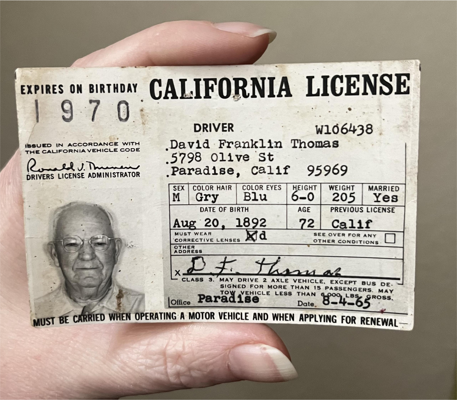

✅ Image loaded: (1437, 1257)


In [72]:
# Load a sample license image
# Update this path to your actual license image
image_path = "../../samples/old_cal_license.png"

if os.path.exists(image_path):
    # Load and display the image
    license_image = Image.open(image_path)
    
    # Resize for display if needed
    display_image = license_image.copy()
    display_image.thumbnail((600, 400))
    display(display_image)
    
    print(f"✅ Image loaded: {license_image.size}")
else:
    print(f"⚠️ Image not found at {image_path}")
    print("Creating a synthetic image for demonstration...")
    
    # Create a simple synthetic image for testing
    from PIL import Image, ImageDraw, ImageFont
    
    license_image = Image.new('RGB', (600, 400), color='white')
    draw = ImageDraw.Draw(license_image)
    
    # Add some text to simulate a license
    text_lines = [
        "DRIVER LICENSE",
        "DL: A1234567",
        "NAME: JANE SMITH",
        "DOB: 05/12/1985",
        "ADDR: 456 OAK AVE",
        "CITY: SAN FRANCISCO, CA 94102",
        "ISS: 06/01/2023 EXP: 06/01/2027"
    ]
    
    y = 50
    for line in text_lines:
        draw.text((50, y), line, fill='black')
        y += 40
    
    display(license_image)
    print("✅ Synthetic image created")

## 7. Example 3: Basic Image Extraction with Direct Bedrock Call

Let's first try extracting from the image using a direct Bedrock API call.

In [73]:
import boto3
import base64
from io import BytesIO


def direct_prompt_with_image():
    parsed_data = None
    
    # Initialize Bedrock client
    bedrock_runtime = boto3.client('bedrock-runtime', region_name=os.environ.get('AWS_DEFAULT_REGION', 'us-east-2'))

    # Convert image to base64
    buffered = BytesIO()
    license_image.save(buffered, format="PNG")
    image_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
    
    # Prepare request for Bedrock with image
    prompt_message = {
        "anthropic_version": "bedrock-2023-05-31",
        "max_tokens": 2000,
        "system": "You are a document assistant. Respond only with JSON. Never make up data, only provide data found in the document being provided.",
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": "image/png",
                            "data": image_base64
                        }
                    },
                    {
                        "type": "text",
                        "text": f"""
\n\n<task>\nYour task is to take the unstructured text provided and convert it into a well-organized table format using JSON. Identify the main entities, attributes, 
or categories mentioned in the attributes list below and use them as keys in the JSON object.  
Then, extract the relevant information from the text and populate the corresponding values in the JSON object.\n</task>\n\n<extraction-guidelines>\n
Guidelines:\n    
1. Ensure that the data is accurately represented and properly formatted within\n    the JSON structure\n    
2. Include double quotes around all keys and values\n    
3. Do not make up data - only extract information explicitly found in the\n    document\n    
4. Do not use /n for new lines, use a space instead\n    
5. If a field is not found or if unsure, return null\n    
6. All dates should be in MM/DD/YYYY format\n    
7. Do not perform calculations or summations unless totals are explicitly given\n    
8. If an alias is not found in the document, return null\n    
9. Guidelines for checkboxes:\n     9.A. CAREFULLY examine each checkbox, radio button, and selection field:\n        
- Look for marks like ✓, ✗, x, filled circles (●), darkened areas, or handwritten checks indicating selection\n        
- For checkboxes and multi-select fields, ONLY INCLUDE options that show clear visual evidence of selection\n        
- DO NOT list options that have no visible selection mark\n     
9.B. For ambiguous or overlapping tick marks:\n        
- If a mark overlaps between two or more checkboxes, determine which option contains the majority of the mark\n        
- Consider a checkbox selected if the mark is primarily inside the check box or over the option text\n        
- When a mark touches multiple options, analyze which option was most likely intended based on position and density. For handwritten checks, the mark typically flows from the selected checkbox outward.\n        
- Carefully analyze visual cues and contextual hints. Think from a human perspective, anticipate natural tendencies, and apply thoughtful reasoning to make the best possible judgment.\n    

10. Think step by step first and then answer.\n\n</extraction-guidelines>\nIf the attributes section below contains a list of attribute names and descriptions, then output only those attributes, using the provided descriptions as guidance for finding the correct values. 
\n<attributes>\n{License.model_json_schema()}\n</attributes>\n\n
<final-instructions>\nExtract key information from the document and return a JSON object with the following key steps: 1. Carefully analyze the document text to identify the requested attributes 
2. Extract only information explicitly found in the document - never make up data 
3. Format all dates as MM/DD/YYYY and replace newlines with spaces 
4. For checkboxes, only include options with clear visual selection marks 
5. Use null for any fields not found in the document 
6. Ensure the output is properly formatted JSON with quoted keys and values 
7. Think step by step before finalizing your answer\n</final-instructions>
"""
                    }
                ]
            }
        ]
    }
    
    # Make the API call
    print("🔍 Making direct Bedrock API call with image...\n")
    response = bedrock_runtime.invoke_model(
        modelId=MODEL_ID,
        body=json.dumps(prompt_message)
    )
    
    # Parse response
    response_body = json.loads(response['body'].read())
    extracted_text = response_body['content'][0]['text']
    
    print("Raw LLM Response:")
    print(extracted_text)
    print("\n" + "="*70 + "\n")
    
    # Try to parse as JSON (may need cleaning)
    try:
        # Remove markdown code blocks if present
        clean_json = extracted_text.strip()
        if '```' in clean_json:
            # Extract content between code blocks
            parts = clean_json.split('```')
            for part in parts:
                if part.strip().startswith('json'):
                    clean_json = part[4:].strip()
                    break
                elif part.strip().startswith('{'):
                    clean_json = part.strip()
                    break
        
        parsed_data = json.loads(clean_json)
        print("✅ Successfully parsed JSON:")
        print(json.dumps(parsed_data, indent=2))
        print("\n⚠️  Note: This is unstructured JSON:")
        print("   - Field names may vary from request")
        print("   - No automatic type validation")
        print("   - No nested Address object structure")
        print("   - Additional manual post-processing needed")
    except json.JSONDecodeError as e:
        print(f"❌ Failed to parse as JSON: {e}")
        print("This demonstrates a key challenge with direct LLM calls - unpredictable response format.")
    except Exception as e:
        print(f"❌ Error: {e}")

    return parsed_data

direct_prompt_with_image()

🔍 Making direct Bedrock API call with image...

Raw LLM Response:
Looking at this California driver's license, I'll extract the information step by step:

1. **Personal Information:**
   - Name: David Franklin Thomas
   - Sex: M (Male)
   - Date of birth: Aug 20, 1892 (converting to MM/DD/YYYY format: 08/20/1892)

2. **Physical Characteristics:**
   - Height: 6-0 (6 feet 0 inches)
   - Weight: 205 (pounds)
   - Eye color: Blu (converting to lowercase: blu)

3. **Address:**
   - Street: 5798 Olive St
   - City: Paradise
   - State: Calif (California, abbreviated as CA)
   - ZIP: 95969

4. **License Details:**
   - Driver license number: W106438
   - Expiration date: The license expires on birthday 1970 (converting to MM/DD/YYYY using birth date: 08/20/1970)
   - Issue date: Looking at the date stamp "8-4-65" (converting to MM/DD/YYYY: 08/04/1965)
   - License class: Looking at the license type section, I can see "CLASS 3" mentioned

```json
{
  "sex": "M",
  "license_class": "3",
  "hei

{'sex': 'M',
 'license_class': '3',
 'height': '6-0',
 'weight': '205',
 'address': {'street': '5798 Olive St',
  'city': 'Paradise',
  'state': 'CA',
  'zip_code': '95969'},
 'eye_color': 'blu',
 'last_name': 'Thomas',
 'first_name': 'David',
 'issue_date': '08/04/1965',
 'date_of_birth': '08/20/1892',
 'expiration_date': '08/20/1970',
 'driver_license_number': 'W106438'}

In [ ]:
# Repeated extraction

valid_data = License(**{
  "sex": "M",
  "license_class": "3",
  "height": "6-0",
  "weight": "205",
  "address": {
    "city": "Paradise",
    "state": "CA",
    "street": "5798 Olive St",
    "zip_code": "95969"
  },
  "eye_color": "BLU",
  "last_name": "Thomas",
  "first_name": "David",
  "middle_name": "Franklin",
  "issue_date": "08/04/1965",
  "date_of_birth": "08/20/1892",
  "expiration_date": "08/20/1970",
  "driver_license_number": "W106438"
})

success_count = 0

for i in range(10):
    print(f"\n\n--- Iteration {i+1} ---")
    parsed_data = direct_prompt_with_image()
    if not (diff := DeepDiff(parsed_data, valid_data.model_dump(), ignore_order=True, ignore_string_case=True)):
        success_count += 1
    else:
        print("\n\n")
        print(diff)

print(f"\n✅ Extraction matched expected data {success_count}/10 times")




--- Iteration 1 ---
🔍 Making direct Bedrock API call with image...

Raw LLM Response:
Looking at this California driver's license, I'll extract the information step by step:

1. **Personal Information:**
   - Name: David Franklin Thomas
   - Sex: M
   - Date of birth: Aug 20, 1892 → 08/20/1892
   - Height: 6-0 → 6'0"
   - Weight: 205
   - Eye color: Blu → blu
   - Hair color: Gry (not requested)

2. **License Details:**
   - Driver license number: W106438
   - Expires on birthday: 1970 → Need to determine expiration date
   - Issue date: 8-4-65 → 08/04/1965
   - License class: Looking at the restrictions section, I can see "CLASS 3"

3. **Address:**
   - Street: 5798 Olive St
   - City: Paradise
   - State: Calif → CA
   - ZIP: 95969

4. **Expiration Date:**
   - The license says "EXPIRES ON BIRTHDAY 1970"
   - Birth date is August 20, 1892
   - So expiration would be 08/20/1970

```json
{
  "sex": "M",
  "license_class": "3",
  "height": "6'0\"",
  "weight": "205",
  "address": {
  

## 8. Example 4: Extract from Image with Structured Output

Now let's use structured output for guaranteed schema compliance and validation.

In [75]:
# Extract from image
if 'license_image' in locals():
    try:
        print("🔍 Extracting information from image...")
        
        result, response = structured_output(
            model_id=MODEL_ID,
            data_format=License,
            prompt=license_image,
            custom_instruction="""
            Extract all visible information from this driver's license image.
            Pay attention to:
            - All text fields and their values
            - Dates should be formatted as MM/DD/YYYY
            - Parse the address into street, city, state, and zip code components
            - Identify first and last names from the full name field
            """
        )
        
        print("✅ Extraction successful!")
        print("\nExtracted License Information:")
        print(json.dumps(result.model_dump(), indent=2))
        
        # Validate the extraction
        print("\n📋 Validation Results:")
        print(f"  - Name: {result.first_name} {result.last_name}")
        print(f"  - License #: {result.driver_license_number}")
        print(f"  - DOB: {result.date_of_birth}")
        print(f"  - Address: {result.address.street}, {result.address.city}, {result.address.state}")
        
    except Exception as e:
        print(f"❌ Extraction failed: {e}")
        import traceback
        traceback.print_exc()

🔍 Extracting information from image...
{"level":"INFO","location":"structured_output_async:470","message":"Setting max_tokens for model","timestamp":"2025-10-10 15:20:54,013+0100","service":"agentic_idp","taskName":"Task-953","max_tokens":64000,"model_id":"global.anthropic.claude-sonnet-4-20250514-v1:0","model_max_tokens":64000}
I'll extract all the visible information from this California driver's license. Let me analyze the image and extract the structured data.
Tool #1: extraction_tool
{"level":"INFO","location":"extraction_tool:202","message":"extraction_tool called","timestamp":"2025-10-10 15:21:03,522+0100","service":"agentic_idp"}
Let me review the extracted data against the source document to ensure accuracy:
Tool #2: view_existing_extraction
{"level":"INFO","location":"view_existing_extraction:252","message":"Current extraction state","timestamp":"2025-10-10 15:21:06,390+0100","service":"agentic_idp","current_extraction":{"sex":"M","license_class":"3","height":"6-0","weight":"

In [ ]:
# Repeated extraction

valid_data = License(**{
  "sex": "M",
  "license_class": "3",
  "height": "6-0",
  "weight": "205",
  "address": {
    "city": "Paradise",
    "state": "CA",
    "street": "5798 Olive St",
    "zip_code": "95969"
  },
  "eye_color": "BLU",
  "last_name": "Thomas",
  "middle_name": "Franklin",
  "first_name": "David",
  "issue_date": "08/04/1965",
  "date_of_birth": "08/20/1892",
  "expiration_date": "08/20/1970",
  "driver_license_number": "W106438"
})

success_count = 0

for i in range(10):
    print(f"\n\n--- Iteration {i+1} ---")
    parsed_data, _ = structured_output(
            model_id=MODEL_ID,
            data_format=License,
            prompt=license_image
        )
    if not (diff := DeepDiff(parsed_data.model_dump(), valid_data.model_dump(), ignore_order=True, ignore_string_case=True)):
        success_count += 1
    else:
        print("\n\n")
        print(diff)

print(f"\n✅ Extraction matched expected data {success_count}/10 times")




--- Iteration 1 ---
{"level":"INFO","location":"structured_output_async:470","message":"Setting max_tokens for model","timestamp":"2025-10-10 15:21:19,090+0100","service":"agentic_idp","taskName":"Task-967","max_tokens":64000,"model_id":"global.anthropic.claude-sonnet-4-20250514-v1:0","model_max_tokens":64000}
I'll extract the structured data from this California driver's license image. Let me analyze all the information visible on the license.
Tool #1: extraction_tool
{"level":"INFO","location":"extraction_tool:202","message":"extraction_tool called","timestamp":"2025-10-10 15:21:26,321+0100","service":"agentic_idp"}
Let me review the extracted data by viewing it to ensure accuracy:
Tool #2: view_existing_extraction
{"level":"INFO","location":"view_existing_extraction:252","message":"Current extraction state","timestamp":"2025-10-10 15:21:31,562+0100","service":"agentic_idp","current_extraction":{"sex":"M","license_class":"3","height":"6-0","weight":"205","address":{"city":"Paradise

## 9. Example 5: Update Existing Data with Patches

Sometimes you might want to update or correct existing extracted data.

In [ ]:
# Create initial extraction with some intentional errors
initial_data = License(
    sex="M",
    license_class="C",
    height="5'10\"",
    weight="175",
    address=Address(
        street="123 Main St",
        city="Los Angeles",
        state="CA",
        zip_code="90001"
    ),
    eye_color="BRN",
    last_name="Doe",
    middle_name="Doe",
    first_name="John",
    issue_date="01/01/2020",  # Wrong date
    date_of_birth="01/25/1990",
    expiration_date="01/01/2024",  # Wrong date
    driver_license_number="D0000000"  # Wrong number
)

print("Initial data (with errors):")
print(json.dumps(initial_data.model_dump(), indent=2))

Initial data (with errors):
{
  "sex": "M",
  "license_class": "C",
  "height": "5'10\"",
  "weight": "175",
  "address": {
    "city": "Los Angeles",
    "state": "CA",
    "street": "123 Main St",
    "zip_code": "90001"
  },
  "eye_color": "BRN",
  "last_name": "Doe",
  "first_name": "John",
  "issue_date": "01/01/2020",
  "date_of_birth": "01/25/1990",
  "expiration_date": "01/01/2024",
  "driver_license_number": "D0000000"
}


In [ ]:
# Update with corrections
correction_prompt = """
Please update the license data with these corrections:
- The issue date should be 03/15/2022
- The expiration date should be 03/15/2026
- The driver license number is D1234567
- The weight should be 180
"""


updated_result, response = structured_output(
    model_id=MODEL_ID,
    data_format=License,
    prompt=correction_prompt,
    existing_data=initial_data,  # Pass existing data to update
    custom_instruction="Apply the specified corrections to the existing data. Keep all other fields unchanged."
)

print("✅ Update successful!")
print("\nUpdated License Information:")
print(json.dumps(updated_result.model_dump(), indent=2))

# Show what changed
print("\n🔄 Changes made:")
if initial_data.issue_date != updated_result.issue_date:
    print(f"  - Issue date: {initial_data.issue_date} → {updated_result.issue_date}")
if initial_data.expiration_date != updated_result.expiration_date:
    print(f"  - Expiration: {initial_data.expiration_date} → {updated_result.expiration_date}")
if initial_data.driver_license_number != updated_result.driver_license_number:
    print(f"  - License #: {initial_data.driver_license_number} → {updated_result.driver_license_number}")
if initial_data.weight != updated_result.weight:
    print(f"  - Weight: {initial_data.weight} → {updated_result.weight}")
    


{"level":"INFO","location":"structured_output_async:466","message":"Setting max_tokens for model","timestamp":"2025-10-09 20:27:56,066+0100","service":"agentic_idp","taskName":"Task-13","max_tokens":64000,"model_id":"global.anthropic.claude-sonnet-4-20250514-v1:0","model_max_tokens":64000}
I'll help you update the license data with the specified corrections. First, let me view the existing data to understand the current structure, then apply the necessary patches.
Tool #1: view_existing_extraction
{"level":"INFO","location":"view_existing_extraction:246","message":"Current extraction state","timestamp":"2025-10-09 20:28:01,059+0100","service":"agentic_idp","current_extraction":{"sex":"M","class_":"C","height":"5'10\"","weight":"175","address":{"city":"Los Angeles","state":"CA","street":"123 Main St","zip_code":"90001"},"eye_color":"BRN","last_name":"Doe","first_name":"John","issue_date":"01/01/2020","date_of_birth":"01/25/1990","expiration_date":"01/01/2024","driver_license_number":"D0

## 10. Advanced: Using with Review Agent

Enable the review agent for additional validation and accuracy.

In [ ]:
# Complex text with potential ambiguities
complex_license_text = """
STATE OF NEW YORK DRIVER LICENSE

License No: N987654321
Class: D (Regular)
Issued on March 3rd, 2023
Valid until March 3rd, 2028

Name: ELIZABETH ANNE JOHNSON-SMITH
Born: February 29, 1992

Address:
Apt 5B, 789 Broadway Avenue
New York City, NY 10013-2468

Physical Description:
Gender: F | Height: 5 feet 6 inches | Weight: 135 lbs | Eyes: Green
"""

try:
    print("🔍 Extracting with review agent enabled...")
    
    result, response = structured_output(
        model_id=MODEL_ID,
        data_format=License,
        prompt=complex_license_text,
        review_agent=True,  # Enable review agent for double-checking
        custom_instruction="""
        Extract license information carefully:
        - Handle hyphenated last names appropriately
        - Convert date descriptions to MM/DD/YYYY format
        - Parse apartment numbers as part of street address
        - Convert height/weight descriptions to standard format
        - Map 'Gender' to 'sex' field
        - Map eye color descriptions to abbreviations (Green -> GRN)
        """
    )
    
    print("✅ Extraction with review successful!")
    print("\nExtracted License Information:")
    print(json.dumps(result.model_dump(), indent=2))
    
    # Check token usage if available
    if 'metering' in response:
        print("\n📊 Token Usage:")
        for model, usage in response['metering'].items():
            if hasattr(usage, 'inputTokens'):
                print(f"  - Input tokens: {usage.inputTokens}")
                print(f"  - Output tokens: {usage.outputTokens}")
                print(f"  - Total tokens: {usage.totalTokens}")
    
except Exception as e:
    print(f"❌ Extraction failed: {e}")
    import traceback
    traceback.print_exc()

🔍 Extracting with review agent enabled...
{"level":"INFO","location":"structured_output_async:466","message":"Setting max_tokens for model","timestamp":"2025-10-09 20:28:09,982+0100","service":"agentic_idp","taskName":"Task-21","max_tokens":64000,"model_id":"global.anthropic.claude-sonnet-4-20250514-v1:0","model_max_tokens":64000}


I'll extract the driver's license information from this New York license document.
Tool #1: extraction_tool
{"level":"INFO","location":"extraction_tool:196","message":"extraction_tool called","timestamp":"2025-10-09 20:28:15,349+0100","service":"agentic_idp","models_extraction":{"sex":"F","class_":"D","height":"5'6\"","weight":"135","address":{"city":"New York City","state":"NY","street":"Apt 5B, 789 Broadway Avenue","zip_code":"10013-2468"},"eye_color":"GRN","last_name":"JOHNSON-SMITH","first_name":"ELIZABETH ANNE","issue_date":"03/03/2023","date_of_birth":"02/29/1992","expiration_date":"03/03/2028","driver_license_number":"N987654321"}}
Perfect! I've successfully extracted all the driver's license information from the New York license document. Here's what I captured:

**Personal Information:**
- Name: ELIZABETH ANNE JOHNSON-SMITH (with hyphenated last name)
- Date of Birth: 02/29/1992 (leap year birthday)
- Sex: F (converted from "Gender: F")

**License Details:**
- License Number: 

## 11. Batch Processing Example

Process multiple licenses in a batch.

In [ ]:
# Sample batch of license texts
license_batch = [
    """
    DL: T111111 | Class: M (Motorcycle)
    Name: Robert Lee | DOB: 07/04/1976
    Address: 100 First St, Austin, TX 78701
    Issued: 01/15/2024 | Expires: 01/15/2032
    Sex: M | Height: 6'0" | Weight: 190 | Eyes: BLU
    """,
    """
    DL#: F222222 | License Type: C
    Maria Garcia, born 12/25/1995
    555 Palm Drive, Miami, FL 33101
    Valid: 09/01/2023 - 09/01/2031
    Female, 5'4", 125 lbs, Brown eyes
    """,
]

# Process batch
extracted_licenses = []
errors = []

for i, license_text in enumerate(license_batch, 1):
    print(f"\n📄 Processing license {i}/{len(license_batch)}...")
    try:
        result, _ = structured_output(
            model_id=MODEL_ID,
            data_format=License,
            prompt=license_text,
            custom_instruction="Parse all information. Infer first and last names from full name."
        )
        extracted_licenses.append(result)
        print(f"  ✅ Success: {result.first_name} {result.last_name}")
    except Exception as e:
        errors.append((i, str(e)))
        print(f"  ❌ Failed: {e}")

# Summary
print(f"\n📊 Batch Processing Summary:")
print(f"  - Total processed: {len(license_batch)}")
print(f"  - Successful: {len(extracted_licenses)}")
print(f"  - Failed: {len(errors)}")

if extracted_licenses:
    print("\n✅ Successfully extracted licenses:")
    for lic in extracted_licenses:
        print(f"  - {lic.first_name} {lic.last_name} ({lic.driver_license_number})")


📄 Processing license 1/2...
{"level":"INFO","location":"structured_output_async:466","message":"Setting max_tokens for model","timestamp":"2025-10-09 20:28:20,831+0100","service":"agentic_idp","taskName":"Task-26","max_tokens":64000,"model_id":"global.anthropic.claude-sonnet-4-20250514-v1:0","model_max_tokens":64000}
I'll extract the driver's license information from the provided data. Let me parse all the information and structure it according to the schema.
Tool #1: extraction_tool
{"level":"INFO","location":"extraction_tool:196","message":"extraction_tool called","timestamp":"2025-10-09 20:28:26,442+0100","service":"agentic_idp","models_extraction":{"sex":"M","class_":"M","height":"6'0\"","weight":"190","address":{"city":"Austin","state":"TX","street":"100 First St","zip_code":"78701"},"eye_color":"BLU","last_name":"Lee","first_name":"Robert","issue_date":"01/15/2024","date_of_birth":"07/04/1976","expiration_date":"01/15/2032","driver_license_number":"T111111"}}
Perfect! I have suc

## 12. Export Results

Save extracted data for further processing.

In [ ]:
# Export to JSON
if extracted_licenses:
    output_data = {
        "extraction_date": datetime.now().isoformat(),
        "model_used": MODEL_ID,
        "total_licenses": len(extracted_licenses),
        "licenses": [lic.model_dump() for lic in extracted_licenses]
    }
    
    output_file = "extracted_licenses.json"
    with open(output_file, 'w') as f:
        json.dump(output_data, f, indent=2)
    
    print(f"✅ Exported {len(extracted_licenses)} licenses to {output_file}")
    
    # Display sample of exported data
    print("\nSample of exported data:")
    print(json.dumps(output_data['licenses'][0] if output_data['licenses'] else {}, indent=2))

✅ Exported 2 licenses to extracted_licenses.json

Sample of exported data:
{
  "sex": "M",
  "class_": "M",
  "height": "6'0\"",
  "weight": "190",
  "address": {
    "city": "Austin",
    "state": "TX",
    "street": "100 First St",
    "zip_code": "78701"
  },
  "eye_color": "BLU",
  "last_name": "Lee",
  "first_name": "Robert",
  "issue_date": "01/15/2024",
  "date_of_birth": "07/04/1976",
  "expiration_date": "01/15/2032",
  "driver_license_number": "T111111"
}


## 13. Tips and Best Practices

### For Jupyter Notebooks:
- Use `structured_output` to avoid asyncio issues
- Alternatively, use `await structured_output_async()` in async cells

### For Better Extraction:
1. **Use descriptive Field annotations** - Help the model understand what to extract
2. **Add validators** - Ensure data quality with Pydantic validators
3. **Enable review_agent** - For critical extractions requiring high accuracy
4. **Provide custom_instruction** - Guide the model for specific scenarios
5. **Use existing_data** - For updates and corrections

### Advantages of Structured Output vs Direct LLM Calls:
- **Guaranteed schema compliance** - Always get valid Pydantic models
- **Built-in validation** - Field validators ensure data quality
- **Type safety** - Strong typing for downstream processing
- **Error handling** - Better error messages and retry logic
- **Consistency** - Same structure every time


## Cleanup

In [ ]:
# Clean up exported files if needed
import os

if os.path.exists('extracted_licenses.json'):
    # os.remove('extracted_licenses.json')
    print("✅ Cleanup complete (uncomment to actually delete files)")
else:
    print("✅ No cleanup needed")

✅ Cleanup complete (uncomment to actually delete files)
